In [6]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from astropy.io import fits
import numpy as np
from PIL import Image

import os

import torch
import torch.nn as nn
from torch.functional import F

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.io import read_image
from torchvision import models

from src.get_data import gen_dataset
from src.auxiliar import plot_fits
from src.log import control

control.debug_mode = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
gen_dataset("""
            SELECT 
            TOP 2000
            det.id, det.ra, det.dec, det.field, det.B, det.A, det.flux_radius_50, det.theta, det.fwhm,
            
            r.r_auto
            FROM "idr4_dual"."idr4_detection_image" AS det 
            
            LEFT OUTER JOIN "idr4_dual"."idr4_dual_r" AS r ON r.id = det.id
            
            WHERE 1 = CONTAINS( POINT('ICRS', det.ra, det.dec), 
                    CIRCLE('ICRS', 0.5, 0.4, 1) ) 
                    AND r.r_auto < 21
    """,
    fits_folder="data/",
    arrays_folder="arrays/"
)

10/03/2024 15:21:56  [info] - get_data.py - gen_dataset() - Insert splus.cloud credentials
10/03/2024 15:22:01  [info] - get_data.py - gen_dataset() - Querying data
10/03/2024 15:22:07  [info] - get_data.py - gen_dataset() - Downloading stamps


In [2]:
class AstroDataset(Dataset):
    def __init__(self, csv_file, images_dir, arrays_dir):
        self.df = pd.read_csv(csv_file)
        self.images_dir = images_dir
        self.arrays_dir = arrays_dir

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.df.iloc[idx, 0] + '.fits.fz')
        array_name = os.path.join(self.arrays_dir, self.df.iloc[idx, 0] + '.npy')
        image_data = np.load(array_name, allow_pickle=True)

        # Assuming image_data is 2D, add a channel dimension and convert to float
        image_data = torch.tensor(image_data, dtype=torch.float).unsqueeze(0)
            
        label = self.df.iloc[idx, 1]  # Assuming the label is in the second column
        label = torch.tensor([label], dtype=torch.float)

        return image_data, label

    def __len__(self):
        return len(self.df)
    

In [4]:
astro_dataset = AstroDataset(csv_file='data.csv', images_dir='data/', arrays_dir='arrays/')

train_size = int(0.8 * len(astro_dataset))
val_size = len(astro_dataset) - train_size

train_dataset, val_dataset = random_split(astro_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)

C:\Users\gusta\AppData\Local\Temp\ipykernel_16128\2300444603.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


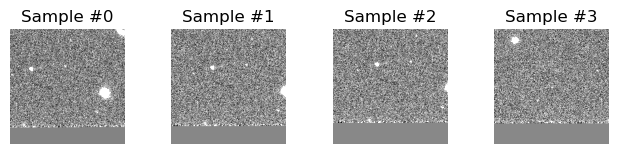

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure()

for i, sample in enumerate(astro_dataset):
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plot_fits(sample[0][0], ax = ax)

    if i == 3:
        plt.show()
        break

In [31]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        
        # Load a pre-trained ResNet model
        self.resnet = models.resnet18(pretrained=True)
        
        # Remove the fully connected layers (or modify accordingly)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])
        
        # Adding custom layers or modifying the architecture
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(self.resnet[-1].in_features, 120)  # Adjust the in_features accordingly
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        # Pass input through ResNet layers
        x = self.resnet(x)
        
        # Flatten the output for the fully connected layer
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [32]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = ConvNet().to(device)
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


c:\Users\gusta\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gusta\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\gusta/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 58.1MB/s]


AttributeError: 'Sequential' object has no attribute 'in_features'

In [26]:

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        
        loss = criterion(outputs.squeeze(), labels)  # Squeeze outputs to match label dimensions
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

[1,     1] loss: 32.393
[2,     1] loss: nan
